
# RNN for Time Series

## Data

https://fred.stlouisfed.org/series/RSAFSNA

### Monthly Sales for Retail Trade and Food Services 

Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly


In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [149]:
df = pd.read_csv('/content/RSCCASN.csv', parse_dates=True, index_col='DATE')
df.head()



,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [151]:


df.columns=['Sales']

In [152]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


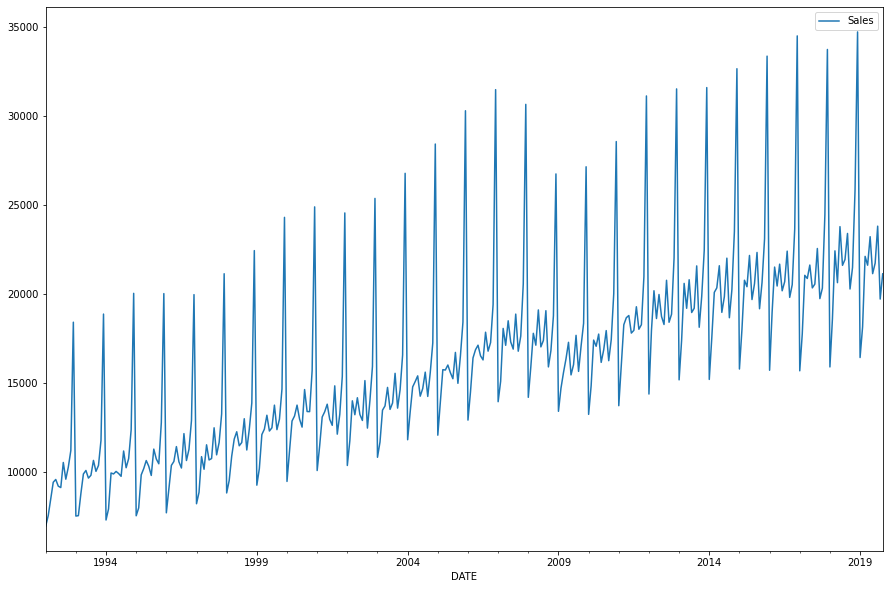

In [153]:
df.plot(figsize=(15,10));

------

## Train, Test Split


In [154]:
len(df)

334

In [155]:
test_size = 24   # 24 months for testing (Data is in `Monthly`)

In [156]:
train = df.iloc[:-test_size]
test = df.iloc[-test_size: ]

In [157]:
train.shape, test.shape

((310, 1), (24, 1))

--------

## Scaling

In [158]:
from sklearn.preprocessing import MinMaxScaler

In [159]:
scaler = MinMaxScaler()

In [160]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

Utility class for generating batches of temporal data.
 
This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

In [161]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [168]:

length = 12
batch_size = 1

generator = TimeseriesGenerator(
    data=scaled_train, 
    targets=scaled_train, 
    length=length, 
    batch_size=batch_size
    )

validation_generator = TimeseriesGenerator(
    scaled_test, 
    scaled_test,
    length=length,
    batch_size=batch_size
    )

In [169]:
X, y = generator[0]

print(f'X : \n{X}')
print(f'y : \n {y}')

X : 
[[[0.        ]
  [0.02127505]
  [0.05580163]
  [0.08942056]
  [0.09512053]
  [0.08146965]
  [0.07860151]
  [0.12979233]
  [0.09566512]
  [0.1203892 ]
  [0.15426227]
  [0.41595266]]]
y : 
 [[0.02047633]]


## Model Building

In [170]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [171]:
n_features = 1

In [172]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [173]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               40800     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


## Early Stopping

In [174]:
from tensorflow.keras.callbacks import EarlyStopping

In [175]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Fit the model

In [176]:
model.fit(generator,
             validation_data = validation_generator,
             epochs=20,
             callbacks=[early_stopping],
             verbose=1)

Epoch 1/20
298/298 [==============================] - 4s 8ms/step - loss: 0.0236 - val_loss: 0.0311
Epoch 2/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0173 - val_loss: 0.0205
Epoch 3/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0141 - val_loss: 0.0379
Epoch 4/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0064 - val_loss: 0.0055
Epoch 5/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 6/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 7/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 8/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 9/20
298/298 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 10/20
298/298 [==============================] - 2s 7ms/step - loss: 9.7429e-04 - val_loss: 7.

In [177]:
losses = pd.DataFrame(model.history.history)

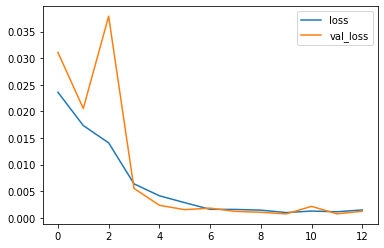

In [178]:
losses.plot();

--------

# Evaluate on Test Data

In [179]:
test_predictions = []

#length = 12, n_features = 1
first_evaluation_batch = scaled_train[-length: ]
current_batch = first_evaluation_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    current_prediction = model.predict(current_batch)[0] # prediction 1 time stamp ahead 
    
    
    # store prediction
    test_predictions.append(current_prediction)
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis=1)

## Inverse Transformations and Compare

In [180]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [181]:
test.head()

,Sales,Predictions
DATE,,
2017-11-01,24438,24085.762115
2017-12-01,33720,36982.960374
2018-01-01,15881,16714.744739
2018-02-01,18585,18602.360321
2018-03-01,22404,21411.316341


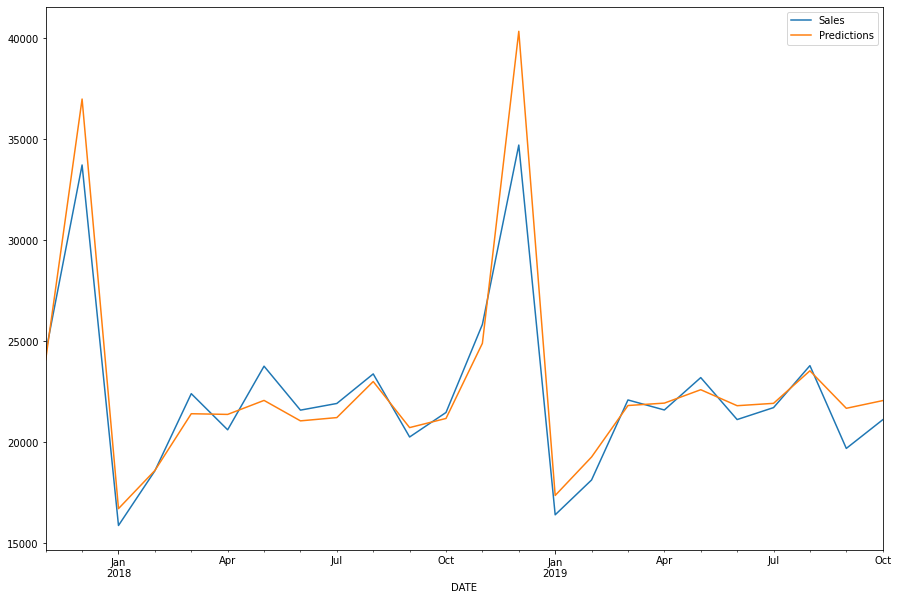

In [182]:
test.plot(figsize=(15,10));

## Training on complete dataset

In [183]:
# Scaling
full_scaler = MinMaxScaler()

In [184]:
scaled_full_data = full_scaler.fit_transform(df)

In [185]:
# Generator 
length = 12
batch_size = 1

generator = TimeseriesGenerator(scaled_full_data, scaled_full_data,
                                                   length=length, batch_size=batch_size)

In [186]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

 ## Forecasting

In [187]:
model.fit(
    generator,
    epochs=10,
    verbose=1)

Epoch 1/10
322/322 [==============================] - 3s 7ms/step - loss: 0.0258
Epoch 2/10
322/322 [==============================] - 2s 7ms/step - loss: 0.0173
Epoch 3/10
322/322 [==============================] - 2s 7ms/step - loss: 0.0108
Epoch 4/10
322/322 [==============================] - 2s 7ms/step - loss: 0.0044
Epoch 5/10
322/322 [==============================] - 2s 7ms/step - loss: 0.0023
Epoch 6/10
322/322 [==============================] - 2s 7ms/step - loss: 0.0018
Epoch 7/10
322/322 [==============================] - 2s 7ms/step - loss: 0.0017
Epoch 8/10
322/322 [==============================] - 2s 7ms/step - loss: 0.0012
Epoch 9/10
322/322 [==============================] - 3s 9ms/step - loss: 0.0016
Epoch 10/10
322/322 [==============================] - 2s 7ms/step - loss: 0.0017


In [188]:

forecast = []

periods = 12

first_evaluation_batch = scaled_full_data[-length: ]
current_batch = first_evaluation_batch.reshape((1, length, n_features))

for i in range(periods):
    current_prediction = model.predict(current_batch)[0]
    
    forecast.append(current_prediction)
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis=1)
    

## Inverse Transform

In [189]:
forecast = full_scaler.inverse_transform(forecast)

## Creating new timestamp index with pandas

In [190]:
df.tail()

,Sales
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


In [191]:
forecast[:2]

array([[26883.86818361],
       [35291.83982468]])

In [192]:
forecast_index = pd.date_range(start='2019-11-01', periods=periods, freq = 'MS') # start with the date where data on full data set ends

In [193]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [194]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=['Forecast'])

forecast_df.head()

,Forecast
2019-11-01,26883.868184
2019-12-01,35291.839825
2020-01-01,17285.083089
2020-02-01,18656.152849
2020-03-01,22615.772823


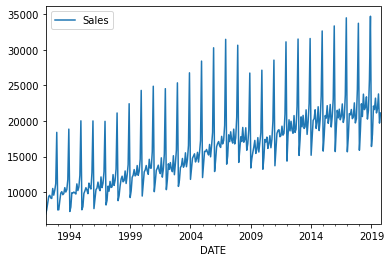

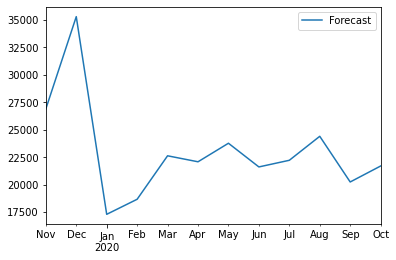

In [198]:
df.plot();
forecast_df.plot();

# Joining pandas plots

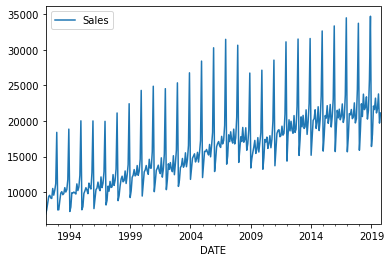

In [199]:
df.plot()


(576.0, 609.0)

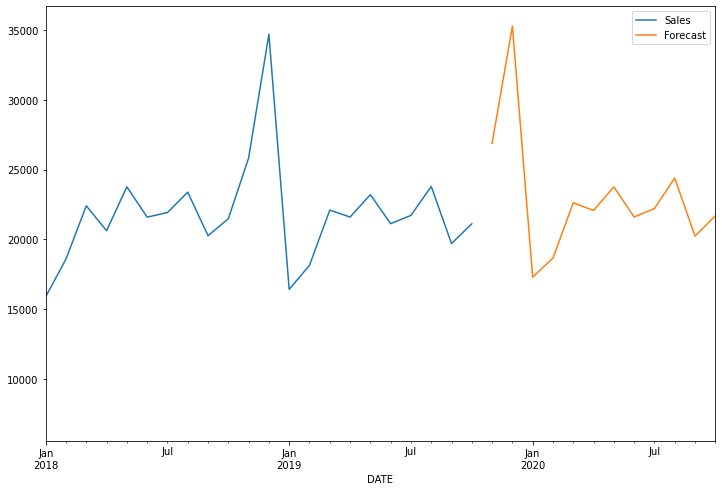

In [202]:
ax = df.plot()
forecast_df.plot(ax=ax, figsize=(12,8))
plt.xlim('2018-01-1', '2020-10-01')